In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14,7)})

In [2]:
#load data
data = pd.read_csv("..\\..\\..\\Data\\Month\\sand500_MinuteToMonth.csv")

In [3]:
data.head()

,LastDayOfMonth,Date,Ticker,Per,Open,High,Low,Close,Vol
0,2010-01-31 23:59:59.999999999,2010-01,SANDP-500,1,1073.72,1073.82,1073.72,1073.82,0
1,2010-02-28 23:59:59.999999999,2010-02,SANDP-500,1,1104.48,1104.48,1104.48,1104.48,0
2,2010-03-31 23:59:59.999999999,2010-03,SANDP-500,1,1169.37,1169.37,1169.37,1169.37,0
3,2010-04-30 23:59:59.999999999,2010-04,SANDP-500,1,1188.06,1188.06,1188.06,1188.06,0
4,2010-05-31 23:59:59.999999999,2010-05,SANDP-500,1,1089.41,1089.41,1089.41,1089.41,0


In [4]:
data['Timestamp'] = pd.DataFrame(data.Date)
data.Date = pd.to_datetime(data.Date)
data = data.sort_values(by=["Date"])
data.Close = data.Close.astype(float) # Here price is equal to close
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Open = data.Open.astype(float)
data = data.drop("Vol", axis = 1)
data = data.drop("Ticker", axis = 1)
data = data.drop("Per", axis = 1)
data = data.drop("LastDayOfMonth", axis = 1)

In [5]:
special_data = pd.DataFrame(data)

In [6]:
special_data = data[(data['Date'] > '2010-01-01') & (data['Date'] < '2015-01-01')]
special_data.index = data.index[:len(special_data)]

In [7]:
#change indexes
special_data.set_index('Date', inplace = True)

In [8]:
data.head(10)

,Date,Open,High,Low,Close,Timestamp
0,2010-01-01,1073.72,1073.82,1073.72,1073.82,2010-01
1,2010-02-01,1104.48,1104.48,1104.48,1104.48,2010-02
2,2010-03-01,1169.37,1169.37,1169.37,1169.37,2010-03
3,2010-04-01,1188.06,1188.06,1188.06,1188.06,2010-04
4,2010-05-01,1089.41,1089.41,1089.41,1089.41,2010-05
5,2010-06-01,1031.03,1031.08,1031.03,1031.08,2010-06
6,2010-07-01,1101.60,1101.60,1101.59,1101.60,2010-07
7,2010-08-01,1048.86,1048.86,1048.46,1048.46,2010-08
8,2010-09-01,1142.50,1142.50,1142.10,1142.10,2010-09
9,2010-10-01,1183.26,1183.26,1183.26,1183.26,2010-10


In [9]:
special_data.head(10)

,Open,High,Low,Close,Timestamp
Date,,,,,
2010-02-01,1104.48,1104.48,1104.48,1104.48,2010-02
2010-03-01,1169.37,1169.37,1169.37,1169.37,2010-03
2010-04-01,1188.06,1188.06,1188.06,1188.06,2010-04
2010-05-01,1089.41,1089.41,1089.41,1089.41,2010-05
2010-06-01,1031.03,1031.08,1031.03,1031.08,2010-06
2010-07-01,1101.60,1101.60,1101.59,1101.60,2010-07
2010-08-01,1048.86,1048.86,1048.46,1048.46,2010-08
2010-09-01,1142.50,1142.50,1142.10,1142.10,2010-09
2010-10-01,1183.26,1183.26,1183.26,1183.26,2010-10


In [10]:
from scalecast.Forecaster import Forecaster
f = Forecaster(y = special_data['Close'], 
               current_dates = special_data.index)

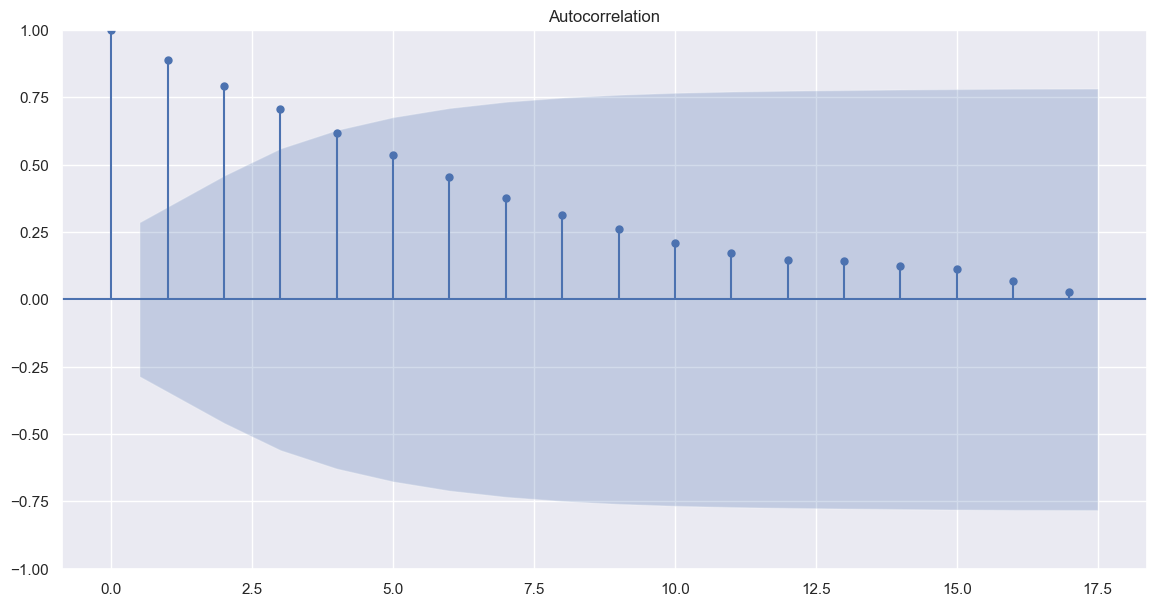

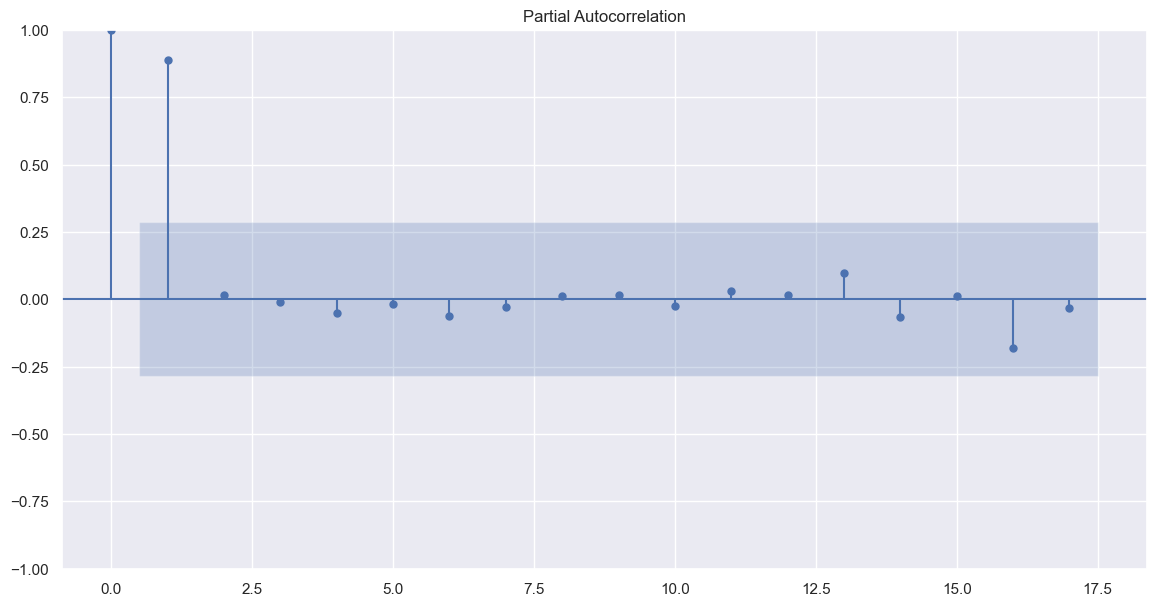

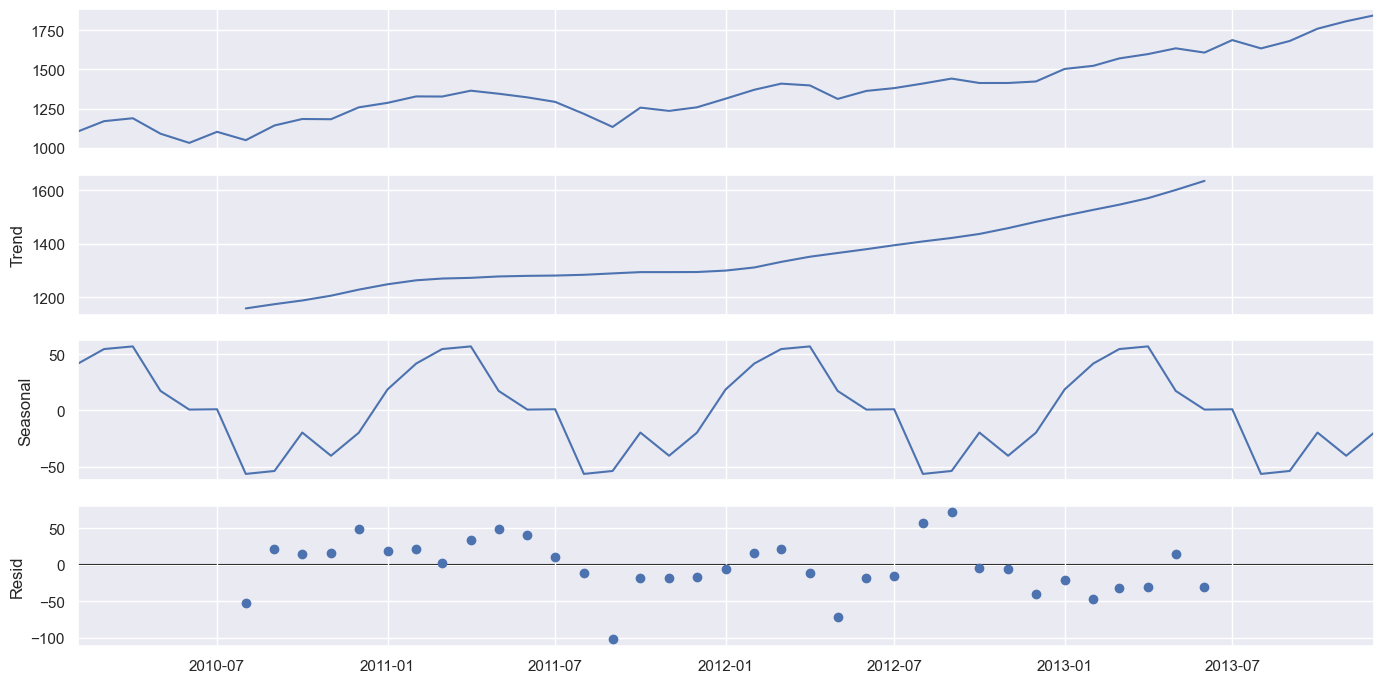

0.3034065972464292
0.9775002403019155


In [11]:
# EDA
f.plot_acf()
plt.show()
f.plot_pacf()
plt.show()
f.seasonal_decompose().plot()
plt.show()
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print(stat)
print(pval)

In [12]:
# Forecast
f.manual_forecast(order=(2,1,1),seasonal_order=(2,1,1,12),call_me='arima2')

# View test results
f.plot_test_set(ci = True,models='arima2')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

# View forecast results
f.plot(ci = True, models = 'arima2')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

# See summary stats
f.regr.summary()

ForecastError: Before calling a model, please make sure you have generated future dates by calling generate_future_dates(), set_last_future_date(), or ingest_Xvars_df(use_future_dates=True).

In [14]:
# Разделение данных на train и test
train_size = int(0.8 * len(special_data))  # 80% данных для обучения
train_data = pd.DataFrame({
    'ds': special_data.iloc[:train_size].index,
    'y' : special_data.iloc[:train_size].Close})
test_data = pd.DataFrame({
    'ds': special_data.iloc[train_size:].index,
    'y' : special_data.iloc[train_size:].Close})

In [15]:
train_size

37

In [17]:
from prophet import Prophet

# Создание и обучение модели Prophet
model = Prophet(daily_seasonality = False)  # Указываем, что у нас есть ежедневная сезонность
model.fit(train_data.reset_index())

20:01:33 - cmdstanpy - INFO - Chain [1] start processing
20:01:35 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# Создание фрейма для прогнозирования
future = pd.DataFrame(index = test_data.index)
future['ds'] = test_data.index

In [19]:
# Получение прогнозов
forecast = model.predict(future)

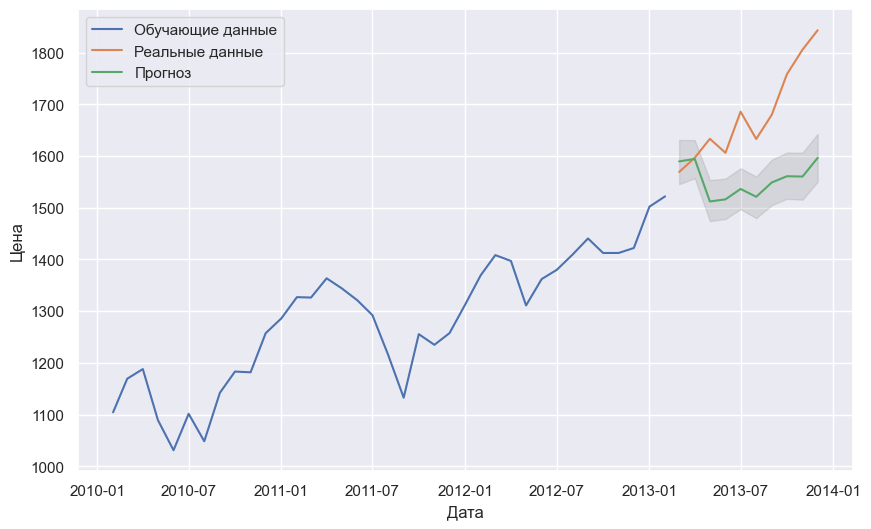

In [20]:
# Визуализация результатов
fig = plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['y'], label='Обучающие данные')
plt.plot(test_data.index, test_data['y'], label='Реальные данные')
plt.plot(test_data.index, forecast['yhat'], label='Прогноз')
plt.fill_between(test_data.index, forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha = 0.2)
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()